# Cost-Optimal Task Scheduling in Battery Assisted Mobile Edge Computing

In [289]:
%reload_ext autoreload
%autoreload 2
%aimport src

from src.sp1 import NetworkFlowProblem

## Parameters

In [290]:
import numpy as np

# baseline problem setup
bl_weights = np.array([
    [0, 8, -2],
    [2, 0, -7],
    [4,2, 0],
])

# subproblem 1 setup
sp_weights = np.array([
    [0, 8, -2],
    [2, 0, -7],
    [4,2, 0],
])

arrival_rates = [4,3,5]

## Baseline

$
\begin{align}
\min_{\mathbf{x}} \quad & \sum_{i}\left[\sum_{j\in\mathcal{B},j\neq i}\frac{p_i c_i^G}{\mu_i}x_{ji} + \sum_{j\in\mathcal{B},j\neq i}\left(c_{ij}-\frac{p_i c_i^G}{\mu_i}\right)x_{ij}\right] \\
s.t. \quad & \sum_{j\in\mathcal{B}, j\neq i} x_{ij}\leq \lambda_i,~i\in\mathcal{B} \\
           & x_{ij}\in\mathbb{N},~i,j\in\mathcal{B},~i\neq j
\end{align}
$

Let 
$$
a_i = \frac{p_i c_i^G}{\mu_i}\quad b_{ij}=\left(c_{ij}-\frac{p_i c_i^G}{\mu_i}\right)
$$
The problem is reformualted as follows.
$
\begin{align}
\min_{\mathbf{x}} \quad & \sum_{i}\left[ \sum_{j\in\mathcal{B}, j\neq i}a_i x_{ji} + \sum_{j\in\mathcal{B}, j\neq i} b_{ij}x_{ij} \right] \\
s.t. \quad & \sum_{j\in\mathcal{B}, j\neq i} x_{ij}\leq \lambda_i,~i\in\mathcal{B} \\
           & x_{ij}\in\mathbb{N},~i,j\in\mathcal{B},~i\neq j
\end{align}
$

<img src="networkflow.png" alt="Drawing" style="width: 600px;"/>

The weight $(u,v)$ from node $u$ to node $v$ follows
$
w_{uv} = a_v + b_{uv} 
$

In [291]:
baseline_problem = NetworkFlowProblem(arrival_rates, bl_weights)
min_cost, _ = baseline_problem.solve()

Baseline min cost: -29


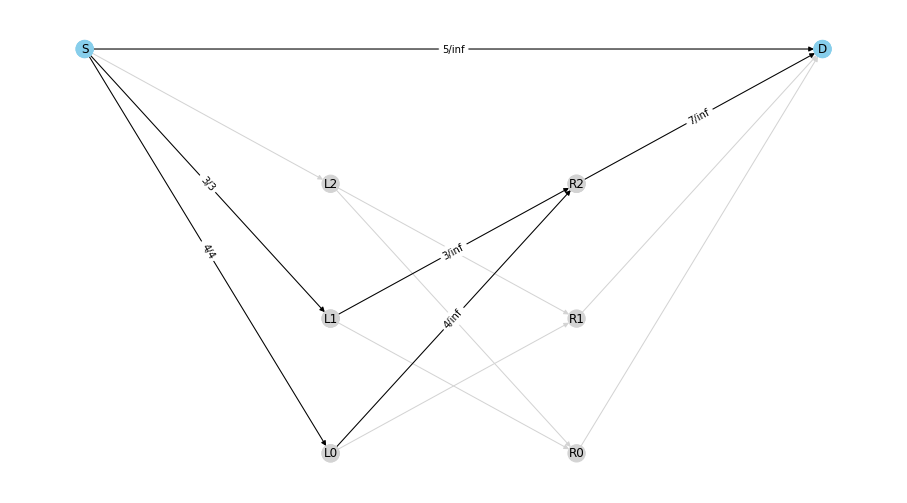

In [292]:
baseline_problem.visualize_flow()
print('Baseline min cost:', min_cost)

## Subproblem 1

$
\begin{align}
\min_{\mathbf{x}} \quad & \sum_{i}\left[ \sum_{j\in\mathcal{B}, j\neq i}\left(\frac{p_i c_i^G}{\mu_i} - \frac{p_i\pi_i}{\mu_i}\right)x_{ji} + \sum_{j\in\mathcal{B}, j\neq i} \left(c_{ij} - \frac{p_i c_i^G}{\mu_i} + \frac{p_i\pi_i}{\mu_i} \right)x_{ij} \right] \\
s.t. \quad & \sum_{j\in\mathcal{B}, j\neq i} x_{ij}\leq \lambda_i,~i\in\mathcal{B} \\
           & x_{ij}\in\mathbb{N},~i,j\in\mathcal{B},~i\neq j
\end{align}
$

Let 
$$
a_i = \left(\frac{p_i c_i^G}{\mu_i} - \frac{p_i\pi_i}{\mu_i}\right) \quad b_{ij} = \left(c_{ij} - \frac{p_i c_i^G}{\mu_i} + \frac{p_i\pi_i}{\mu_i} \right)
$$
The problem is reformualted the same as the baseline. 


In [293]:
subproblem_1 = NetworkFlowProblem(arrival_rates, sp_weights)
min_cost, flow_dict = subproblem_1.solve()

In [295]:
subproblem_1.X

matrix([[0, 0, 4],
        [0, 0, 3],
        [0, 0, 0]])

SP1 min cost: -29


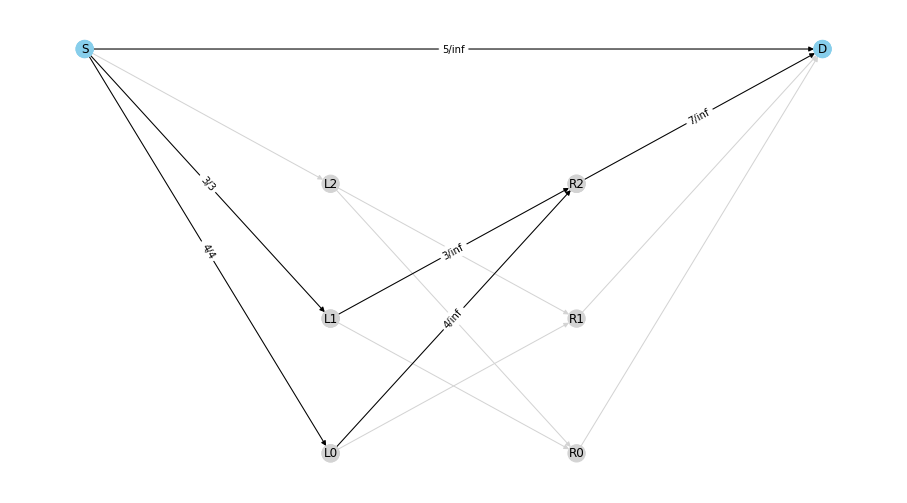

In [279]:
subproblem_1.visualize_flow()
print('SP1 min cost:', min_cost)

## Subproblem 2

$$
\forall i\in\mathcal{B}  \quad \min_{P\geq 0} \sum_{i}\left[ \alpha \left(\frac{P}{P_i^S}\right)^{k_p} - P(c_i^G-c_i^D-\pi_i) \right]
$$

Define
$$
g(P) = \alpha \left(\frac{P}{P_i^S}\right)^{k_p} - P(c_i^G-c_i^D-\pi_i)
$$
Let
$$
a_{i} = \frac{\alpha}{(P_i^S)^{k_p}}\quad b_i = (c_i^G-c_i^D-\pi_i)
$$
Then 
$$
g(P) = a_i P^{k_p} -b_i P
$$
And 
$$
g'(P) = a_i k_p P^{k_p-1} - b_i
$$

Therefore
$$
P^{*} = \left\{
\begin{array}{ll}
\left(\frac{b_i}{a_i k_p}\right)^{\frac{1}{k_p-1}} & b_i \geq 0 \\
 0 & \text{otherwise}
\end{array}\right.
$$


In [272]:
from src.sp2 import DischargingProblem

subproblem_2 = DischargingProblem(alpha=1, Ps=4, kp=3, cG=10, cD=1, pi=2)

In [273]:
subproblem_2.solve()

5.220201853215574

In [275]:
np.array([2,3,5]) ** 3

array([  8,  27, 125])

In [277]:
np.zeros((2,3))

array([[0., 0., 0.],
       [0., 0., 0.]])